In [1]:
import re
import random
from collections import Counter
import string

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Text to words

In [2]:
TEXT = open("/home/dola/ws/data/text8").read()
len(TEXT)

100000000

In [3]:
def tokens(text):
    return re.findall(r"[a-z]+", text.lower())

In [4]:
tokens("This is: A test, 1, 2, 3, this is.")

['this', 'is', 'a', 'test', 'this', 'is']

In [5]:
WORDS = tokens(TEXT)
len(WORDS)

17005207

In [6]:
random.sample(WORDS, 5)

['company', 'national', 'waiting', 'these', 'zero']

## Models by Bag of words

In [9]:
## bag of words model
COUNTS = Counter(WORDS)

In [10]:
COUNTS.most_common(5)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201)]

<IPython.core.display.Javascript object>


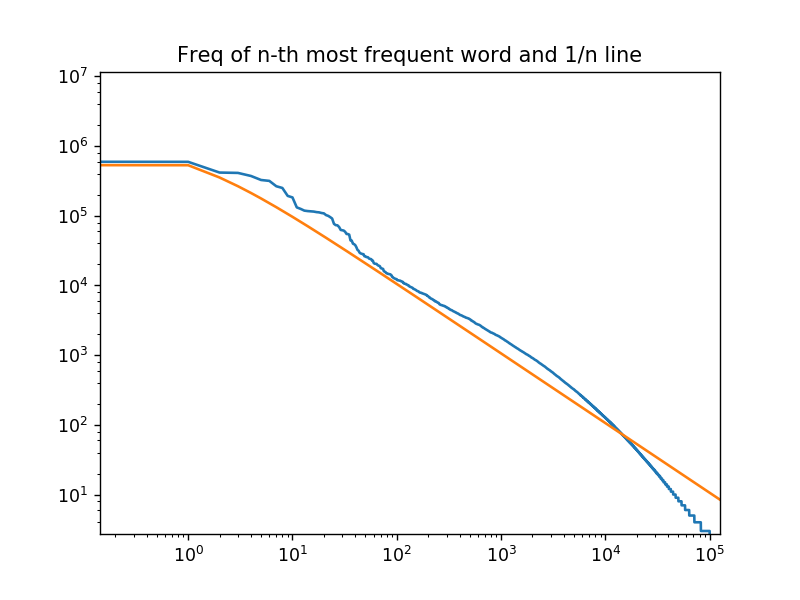

In [13]:
## verify zipf law
M = COUNTS["the"]
plt.yscale("log")
plt.xscale("log")
plt.title("Freq of n-th most frequent word and 1/n line")
plt.plot([c for w, c in COUNTS.most_common()])
plt.plot([M/i for i in range(1, len(COUNTS)+1)])

## Spelling Correction
**Approach**: try all candidates that are known words and close enough to the original one (defined as within a threshold of edit distance)

In [51]:
def correct(word):
    """Find the best spelling correction for the word"""
    candidates = (known(edits0(word)) or
                  known(edits1(word)) or
                  known(edits2(word)) or
                  [word])
    return max(candidates, key=COUNTS.get)

In [52]:
def known(words):
    return {w for w in words if w in COUNTS}

def edits0(word):
    return {word}

def edits2(word):
    return {w2 for w1 in edits1(word) for w2 in edits1(w1)}

In [53]:
def edits1(word):
    pairs = splits(word)
    deletes = [a + b[1:] for (a, b) in pairs if b]
    transposes = [a + b[1] + b[0] + b[2:] for (a, b) in pairs if len(b) >= 2]
    replaces = [a + c + b[1:] for (a, b) in pairs for c in alphabet if b]
    inserts = [a + c + b for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    return [(word[0:i], word[i:len(word)]) for i in range(0, len(word)+1)]

alphabet = string.ascii_lowercase

In [64]:
correct("speling")

'spelling'

## Sequence probability

In [66]:
# create probability from counts
def pdist(counter):
    N = sum(counter.values())
    return lambda x: counter[x] / N

P = pdist(COUNTS)

In [68]:
for w in tokens('"The" is most common word in English'):
    print (P(w), w)

0.06241594118789615 the
0.010770406970053348 is
0.0015032454471151102 most
0.00045268487469749707 common
0.0003338977290896841 word
0.021887472466521576 in
0.0006979038832047149 english


In [72]:
def Pwords(words):
    return product(P(w) for w in words)

def product(xs):
    result = 1
    for x in xs:
        result *= x
    return result

In [73]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print (Pwords(tokens(test)), test)

6.92419025160357e-11 this is a test
2.8624795610411035e-15 this is a unusual test
0.0 this is a neverbeforeseen test


## Word segmentation
**Approach**:
Greedy search: 
1. split into the first word and rest words, based on the maximum Pwords probability
2. do it recursively

**Efficiency**:
To avoid re-calculate the segmentation of the remaining words, exither use *dynamic programming* explictly or *memorization* implicitly.

In [74]:
def memo(f):
    cache = {}
    def memof(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    memof.cache = cache
    return memof

In [75]:
max(len(w) for w in COUNTS)

100

In [76]:
max(COUNTS, key=len)

'bababadalgharaghtakamminarronnkonnbronntonnerronntuonnthunntrovarrhounawnskawntoohoohoordenenthurnuk'

In [81]:
def splits(text, start=0, L=20):
    """return a list of all (first, rest) pairs.
    start <= len(first) <= L"""
    return [(text[:i], text[i:])
           for i in range(start, min(len(text), L)+1)]

In [82]:
splits("reallylongtext", 1, 4)

[('r', 'eallylongtext'),
 ('re', 'allylongtext'),
 ('rea', 'llylongtext'),
 ('real', 'lylongtext')]

In [101]:
@memo
def segment(text):
    if not text:
        return []
    else:
        candidates = ([first] + segment(rest)
                     for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [104]:
segment("choosepain")

['choose', 'pain']

In [105]:
segment("speedofart")

['speed', 'of', 'art']

In [107]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')
" ".join(segment(decl))

'when in the course of human events it becomes necessary for one people to dissolve the political bands which have connected them with another and to assume among the powers of the earth the separate and equal station to which the laws of nature and of natures god entitle them'